## Simulated Data Generating Process (DGP)

Sensor n° 1, 2, and 3

For $t<T_1$:

* y_1 ~ N(mu_1, sigma_1)
* y_2 ~ N(mu_2, sigma_2)
* y_3 ~ N(mu_3, sigma_3)

For $t>=T_1$:

* y_1 ~ N(mu_11, sigma_1) -> Mean Drift!
* y_2 ~ N(mu_2, sigma_2)
* y_3 ~ N(mu_3, sigma_3)

For $t>=T_2$:

* y_1 ~ N(mu_11, sigma_1) -> Mean Drift (started at $T_1$)
* y_2 ~ N(mu_2, sigma_2)
* y_3 ~ N(mu_33, sigma_3) -> Mean Drift!


In [1]:
from kafka import KafkaProducer
import time
import datetime
import json
import numpy as np
import random
from utils.kafka_sender import plot_sens_obs, plot_drift_stream
from utils.kafka_sender import sudden_mean_drift, gradual_mean_drift, sudden_sigma_drift, gradual_sigma_drift
from schemas.schema_sensor import SensorParams, DriftParams

In [2]:
drift_events_sens_1 = [
                        {"drift-event": DriftParams(mu_drift=25,
                                                   t0_drift=10,
                                                   duration_drift=50)},
                       
                        {"drift-event": DriftParams(mu_drift =30,
                                                    t0_drift = 100, 
                                                    duration_drift=70)}
                        ]

drift_events_sens_3 = [                        
                        {"drift-event": DriftParams(mu_drift =50,
                                                   t0_drift = 10,
                                                   duration_drift=30,
                                                   drift_type="mean-gradual")},

                        {"drift-event": DriftParams(mu_drift =50,
                                                    t0_drift = 150,
                                                    duration_drift=30,
                                                    drift_type="mean-gradual")},
                      ]

In [3]:
# Configurations
SEED=42

params_sens1 = SensorParams(sensor_name="sensor-1",
                            mu=2,
                            sigma=3,
                            eps=0.1,
                            max_delay=.1,
                            drifts=drift_events_sens_1
                            )
params_sens2 = SensorParams(sensor_name="sensor-2",
                            mu=3.5,
                            sigma=3,
                            eps=0.1,
                            max_delay=.1,
                            eps_nan = .01
                            )
params_sens3 = SensorParams(sensor_name="sensor-3",
                            mu=1,
                            sigma=3,
                            eps=0.1,
                            eps_nan=0,
                            max_delay=.1,
                            drifts=drift_events_sens_3
                            )

In [4]:
def send_sensor_data(producer: KafkaProducer, topic: str, params: SensorParams, time_step: int) -> tuple:
    """Send sensor data to Kafka topic with specified parameters.
    Args:
        producer (KafkaProducer): Kafka producer instance.
        topic (str): Kafka topic to send data to.
        params (SensorParams): Parameters for the sensor data generation.
        time_step (int): Time step
    Returns:
        tuple: Generated data value and the time taken to send the data.
    """
    noise = params.eps * np.random.normal(0, 1)
    drift = 0
    data_value = np.random.normal(params.mu, params.sigma) + noise

    if params.drifts:
        for _, drift_event in enumerate(params.drifts):
            drift_info = drift_event['drift-event']
            t0 = drift_info.t0_drift
            delta = drift_info.duration_drift
            if t0 <= time_step <= t0 + delta:
                if drift_info.drift_type == "mean-sudden":
                    data_value,\
                        drift = sudden_mean_drift(drift_info=drift_info, 
                                                    params=params)
                elif drift_info.drift_type == "sigma-sudden":
                    data_value,\
                        drift = sudden_sigma_drift(drift_info=drift_info, 
                                                     params=params)
                elif drift_info.drift_type == "mean-gradual":
                    data_value, \
                        drift = gradual_mean_drift(drift_info=drift_info, 
                                                   params=params, 
                                                   time_step=time_step)
                elif drift_info.drift_type == "sigma-gradual":
                    data_value, \
                        drift = gradual_sigma_drift(drift_info=drift_info, 
                                                   params=params, 
                                                   time_step=time_step)
                    
                break

    missing = np.random.random()
    if missing < params.eps_nan:
        data_value = None

    delay_value = np.random.uniform(0, params.max_delay)
    data_sent={'sensor': params.sensor_name,
               'info': {'timestamp_sent': (datetime.datetime.now()-datetime.timedelta(seconds=delay_value)).strftime('%Y-%m-%d %H:%M:%S'),
                        'timestamp_received': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                        'obs': data_value,
                        'drift': drift}}
    try:
        future= producer.send(topic, value=data_sent)
        record = future.get(timeout=10)
        #print(f"Message delivered: device-{params.sensor_name}:topic-{record.topic}:partition-{record.partition}")
    except Exception as e:
        print(f"Error sending data to Kafka: {e}")
            
    return data_value, drift

In [5]:
producer = KafkaProducer(bootstrap_servers='localhost:9092', 
                         value_serializer=lambda v: json.dumps(v).encode('utf-8'))

In [6]:
np.random.seed(SEED)

list_sensobs_1=[]
list_drifts_1=[]

list_sensobs_2 = []
list_drifts_2=[]

list_sensobs_3=[]
list_drifts_3=[]

i=0

#while True:
for _ in range(200):

    print("--"*20)
    print(f"Time step {i}")
    print(" ")
    
    # Sensor-1
    data_1, \
        drift_1 = send_sensor_data(producer=producer,
                                           topic="sensors",
                                           params=params_sens1,
                                           time_step=i)
    # Sensor-2
    data_2, \
        drift_2 = send_sensor_data(producer=producer,
                                           topic="sensors",
                                           params=params_sens2,
                                           time_step=i)
    # Sensor-3
    data_3, \
        drift_3 = send_sensor_data(producer=producer,
                                           topic="sensors",
                                           params=params_sens3,
                                           time_step=i)

    list_sensobs_1.append(data_1)
    list_drifts_1.append(drift_1)

    list_sensobs_2.append(data_2)
    list_drifts_2.append(drift_2)

    list_sensobs_3.append(data_3)
    list_drifts_3.append(drift_3)

    print(" ")
    print(f"[sensor-1] Obs: {data_1}, Drift: {drift_1}")
    print(f"[sensor-2] Obs: {data_2}, Drift: {drift_2}")
    print(f"[sensor-3] Obs: {data_3}, Drift: {drift_3}")

    i+=1  # increase count

    #time.sleep(5)

----------------------------------------
Time step 0
 
 
[sensor-1] Obs: 1.6348785117875693, Drift: 0
[sensor-2] Obs: 2.774173791680125, Drift: 0
[sensor-3] Obs: 3.4602254690094654, Drift: 0
----------------------------------------
Time step 1
 
 
[sensor-1] Obs: 3.580732692164399, Drift: 0
[sensor-2] Obs: -2.2156445068167896, Drift: 0
[sensor-3] Obs: 1.8414588857523793, Drift: 0
----------------------------------------
Time step 2
 
 
[sensor-1] Obs: 1.4692359754325484, Drift: 0
[sensor-2] Obs: 3.77832949667708, Drift: 0
[sensor-3] Obs: 0.06485488162828916, Drift: 0
----------------------------------------
Time step 3
 
 
[sensor-1] Obs: -1.1744825093414946, Drift: 0
[sensor-2] Obs: -0.0802764587027478, Drift: 0
[sensor-3] Obs: 1.4577651027175276, Drift: 0
----------------------------------------
Time step 4
 
 
[sensor-1] Obs: 2.5879515015694525, Drift: 0
[sensor-2] Obs: 2.5851240849933097, Drift: 0
[sensor-3] Obs: 4.1253028015607685, Drift: 0
----------------------------------------

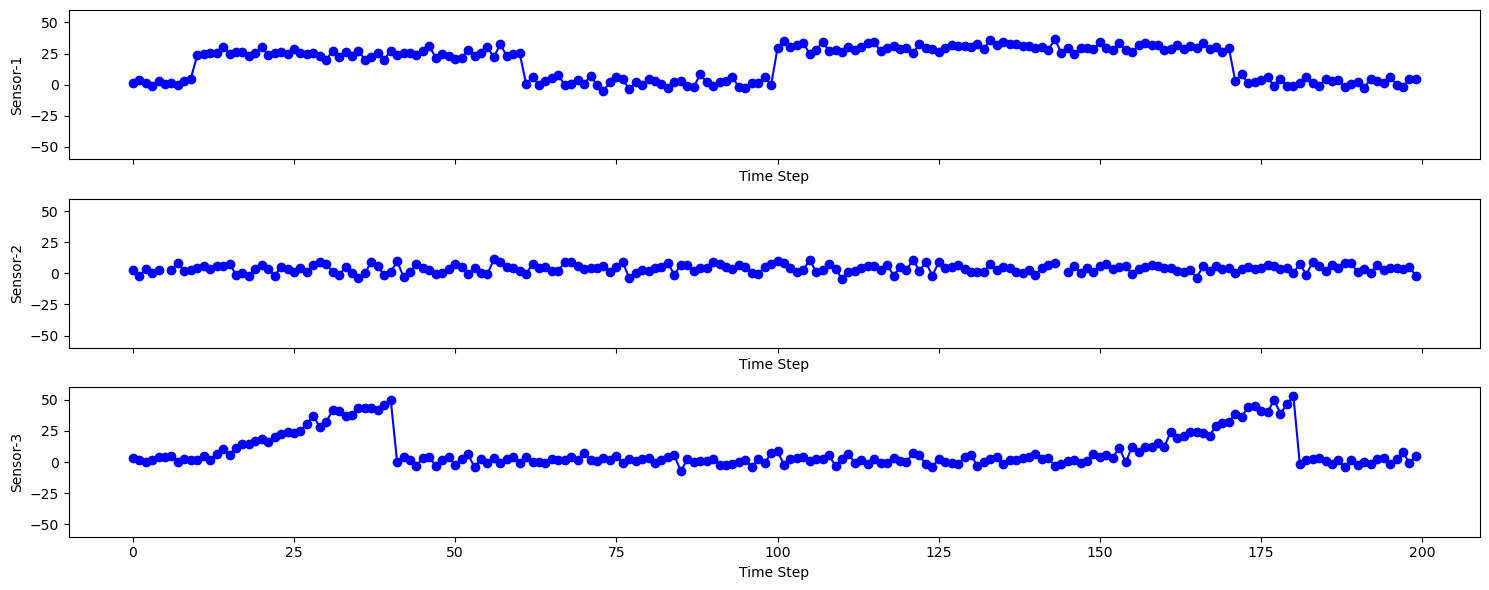

In [7]:
obs_data_stream = np.array([list_sensobs_1, list_sensobs_2, list_sensobs_3])

# plot sensor observations
y_upper_limit= 60
y_lower_limit= -60
plot_sens_obs(obs_data_stream, ylim_low=y_lower_limit, ylim_up=y_upper_limit)

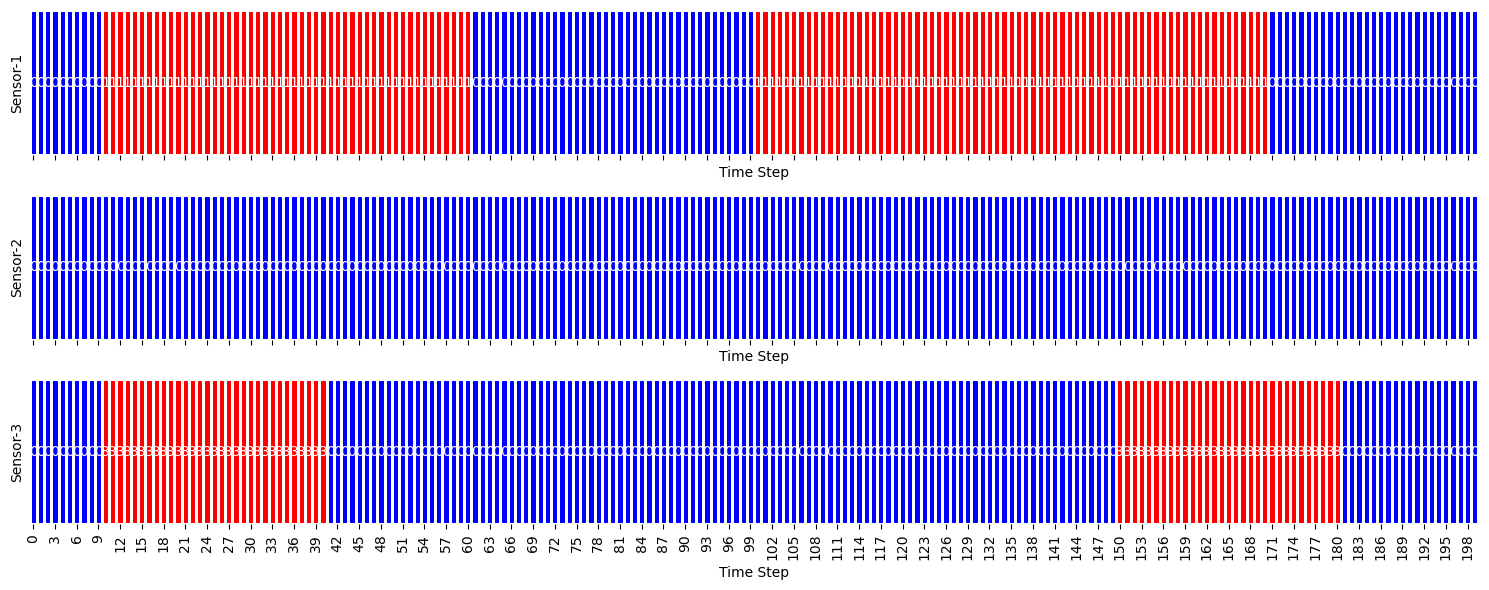

In [8]:
drift_data_stream = np.array([list_drifts_1, list_drifts_2, list_drifts_3])

# plot drifts in data streams
plot_drift_stream(drift_data_stream)